In [3]:
# Load packages used in this notebook
import os
import json
import numpy as np
import pickle
import pandas as pd

from cmdstanpy import CmdStanModel, cmdstan_path, install_cmdstan

import matplotlib.pyplot as plt

%load_ext pycodestyle_magic

import warnings
warnings.filterwarnings('ignore')

#%pycodestyle_off

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Beyond the Numerical Bayesian Inference Algorithm: Glicko2

Final project for Alp Küçükelbir's Machine Learning Probabilistic Programming (COMS6998) course. The outline of the project is as follows:

**0. [Introduction](#Introduction)**
    
    The Goal of the project.

**1. [Model](#Model)**
    
    We introduce Gliko2 ranking system, and its generative story
    
**3. [Inference](#Inference)**
    
    We experiment with four different inference algorithms. Namely, Hamiltonian Monte-Carlo Markov Chain, Mean-Field Variational Inference, Maximum a-Posteriori inference, and Glickman's original inference algorithms.
    
**4. [Criticism](#Criticism)**

    We compare the inference algorithms within and between each other using posterior predictive checks (PPC), and performance metrics.

# Introduction <a id='Introduction'></a>

**Goal:** Based on "Dynamic paired comparison models with stochastic variances" (http://www.glicko.net/research/dpcmsv.pdf). The model consists of ranking players in a stochastic variance modeling setting similar to, famous statistical model, **GARCH**. The paper represents a coupling of a model and an approximate Bayesian inference algorithm that marginalizes the model likelihood using the prior distribution of opponents which may result in information loss. In this project, we experiment with the inference algorithms tought in the lecture to investigate if we can improve the ranking algorithm.

**Box's Loop**

![Box's Loop](./boxsloop.png)


## 1. Data <a id='Data'></a>

To solve this problem we use a combination of the Lichess API (https://lichess.org/api) and the Deloitte/FIDE Chess Rating Challenge data, which are both publicly available. The FIDE data set consists of 135 months of professional chess game results (win, draw or loss) including more than 1,840,124 games between 14,118 unique players. The Lichess data has many more games readily available as one of the most popular online chess platforms. 

Please see ./data/ for more details.

## 2. Model <a id='Model'></a>

The generative story of the model is as follows:

Draw $\omega^2| 4, 2 \sim InverseGamma(4, 2)$ 

Draw $\tau^2 | 4, 1.5 \sim InverseGamma(4, 1.5)$

For $i \in \{1,2\dots, N\}$:

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit variance for $t=0$ $\;$ $\sigma^{2^{(0)}}_i | 4, 2 \sim InverseGamma(4,2) $

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit for $t=0$ $\;$ $\gamma_i^{0} | \omega^2 \sim {N}(0, \omega^2)$

For $i \in \{1,2\dots, N\}$:

$\;\;\;\;\;$For $t \in \{1,2, \dots T\}$:

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit variance $\;$ $\log \sigma^{2^{(t+1)}}_i | \sigma^{2^{(t)}}_i, \tau^2 \sim \mathcal{N}(\log \sigma^{2^{(t)}}_i, \tau^2) $

$\;\;\;\;\;$$\;\;\;\;\;$ Draw player merit $\;$ $\gamma_i^{(t+1)} | \rho, \sigma^{2^{(t+1)}}_i \sim {N}(\rho \gamma_i^{(t)}, \sigma^{2^{(t+1)}}_i)$

$\;\;\;\;\;$$\;\;\;\;\;$ For $j \in \mathcal{O}_i^{(t)}$:

$\;\;\;\;\;$$\;\;\;\;\;$$\;\;\;\;\;$ Draw score $\;$ $s_{ij}^{(t)} \sim Bernoulli(S(\gamma_i^{(t)} - \gamma_j^{(t)}))$

The model we work is based on a popular Bayesian statistical model called Glicko2, an extension of Glicko model, which is the first Bayesian rating model that models uncertainity of player merits in a time dependent manner. In Glicko2, the latent merit/skills of each player are drawn from a Normal distribution, and the variance of normal distribution are drawn from lognormal distribution. Morover, the probability of winning is modeled by a logistic curve. 

# 3. Inference <a id='Inference'></a>

In [4]:
from inference.inference import (
    hmc, 
    meanfield_vi,
    map_opt,
    glickman
)

glicko_stan = './model/model.stan'
chess_data = './data/processed/data.pkl'

observed_data = pickle.load(open(chess_data, 'rb'))
glicko_stan = CmdStanModel(stan_file=glicko_stan)

INFO:cmdstanpy:found newer exe file, not recompiling


We make posterior predictive checks. However, it can be hard making posterior predictive checks in a discrete setting. (write this to critisizm ?)

## 1.Hamiltonian Monte Carlo Markov Chain (HMC)

In this section, we make Bayesian inference by sampling. Specifically, as thought in the class, we sample from the analytically intractable posterior and use them while reasoning about the model. The training procedure and a convergence metric, namely **trace plot** for a parameter $\gamma_{22}$, are as follows:

Exception ignored in: <function tqdm.__del__ at 0x7f884b0d09d0>
Traceback (most recent call last):
  File "/home/mk4139/miniconda3/envs/probprog/lib/python3.9/site-packages/tqdm/std.py", line 1147, in __del__
    self.close()
  File "/home/mk4139/miniconda3/envs/probprog/lib/python3.9/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


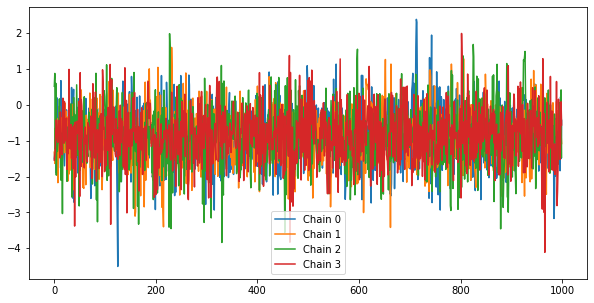

In [5]:
glicko_mcmc, score_pp_mcmc = hmc(
    glicko_stan,
    observed_data,
)

Some example MCMC statistics:

In [10]:
candidate_parameters = ['gamma[1,4]', 'gamma[8,8]']
print(glicko_mcmc.summary().loc[candidate_parameters])

            Mean   MCSE  StdDev    5%   50%  95%   N_Eff  N_Eff/s  R_hat
name                                                                    
gamma[1,4]  0.51  0.011    0.78 -0.78  0.51  1.8  4906.0      8.6    1.0
gamma[8,8]  1.10  0.014    0.77 -0.17  1.10  2.3  3188.0      5.6    1.0


We see that chains are mixed together, potentially forming $R$ values close to $1$. We also observe this at the above table.

## 2. Mean-Field Variational Inference (VI)

In this section, we use mean-field variational family to approximate the intractavle posterior distribution. The training procedure and a convergence metric, namely **ELBO** by iteration, are as follows:

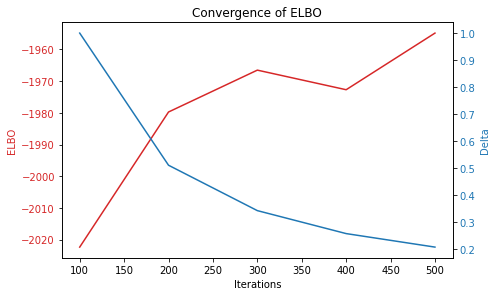

In [11]:
glicko_vi, score_pp_vi = meanfield_vi(
    glicko_stan,
    observed_data
)

The **ELBO** converges to a local optimum point, smoothly, as seen at the above figure. That is the $\Delta$ between each iteration approaches to a small quantity, $\epsilon$, and the optimization algorithm terminates automatically.

## 3. Maximum a-posteriori Inference (MAP)

In this section, we model the intractable posterior distribution using a Dirac-delta function. This leads to MAP estimate for model parameters:

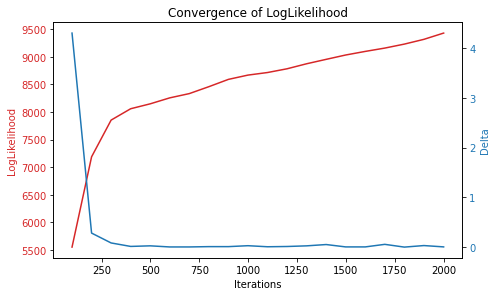

In [12]:
glicko_map, score_pp_map = map_opt(
    glicko_stan,
    observed_data
)

The **LogLikelihood** converges to a local optimum point, smoothly, as seen at the above figure. That is the $\Delta$ between each iteration approaches to a small quantity, $\epsilon$, and the optimization algorithm terminates automatically.

## 4. Glickman's Algorithm

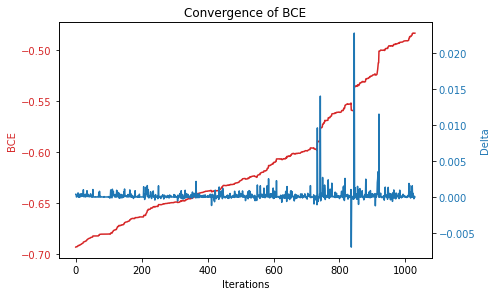

In [127]:
score_pp_glickman, glicko_test_probs = glickman(observed_data)

The Bernoulli likelihood of Glickman's algorithm monotonically increases as we perform numberical updates. We observe that the variance of $\Delta$s are larger compared to the previous gradient based algorithms.

## 4. Criticism  <a id='Criticism'></a>

In this section, we criticize our inference algorithms using posterior predictive checks (PPC). Moving forward, we compare the algorithms with each other using the predictions generated by the posterior predictive distribution (for MCMC, VI, and Glickman's algorithm) and point estimates (for MAP algorithm).

In [30]:
from criticism.criticism import plot_ppc
dim = 'period'
check = [
    'Sum', 
    'Min',
    'Max'
]

### 1.Posterior Predictive Checks:

It is hard making posterior predictive checks for Bernoulli distribution. This is because Bernoulli distribution's support is in between $\{0,1\}$, and therefore, test statistics such as minimum and maximum may not be very informative. 

This leads us defining a new random variables for making posterior predictive checks:

1. $X_{total}^{emp}$: Average number of time white player wins throughout all periods.

   $X_{total}^{syn}:$: Average number of time white player wins throughout all periods, predicted by model.
   
   
2. $X_{std}^{emp}$: The standard deviation of white player wins throughout all periods.

   $X_{std}^{syn}:$: The standard deviation of white player wins throughout all periods, predicted by model.
   
   
3. $X_{min}^{emp}$: The minimum of white player wins throughout all periods.

   $X_{min}^{syn}:$: The minimum of white player wins throughout all periods, predicted by model.
   
   
4. $X_{max}^{emp}$: The maximum of white player wins throughout all periods.

   $X_{max}^{syn}:$: The maximum of white player wins throughout all periods, predicted by model.
   
We are interested in $P(T(X_{*}^{synt}) > T(X_{*}^{emp}))$. Where $T$ changes w.r.t. above items. As an example,  $T$ is the function that takes the average over the number of wins throughout the periods for the first case.

We follow the same procedure as http://www.stat.columbia.edu/~gelman/research/published/dogs.pdf.

**HMC Algorithm:**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **HMC** algorithm:

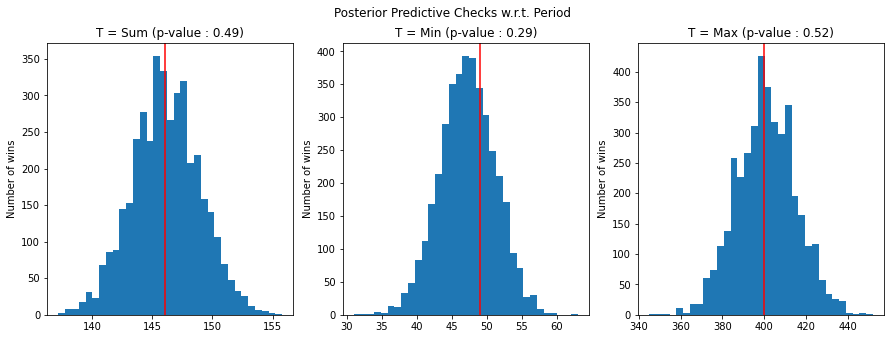

In [31]:
plot_ppc(
    score_pp_mcmc, 
    observed_data,
    check,
    dim
)

The simulated and generated data are good fit in terms of $T$=Sum and $T$=Max. However, the distribution of  $T$=Min is right-skewed which may indicate there may be improvement opportunities in the model.

**Mean-field VI Algorithm:**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **Mean-field VI** algorithm:

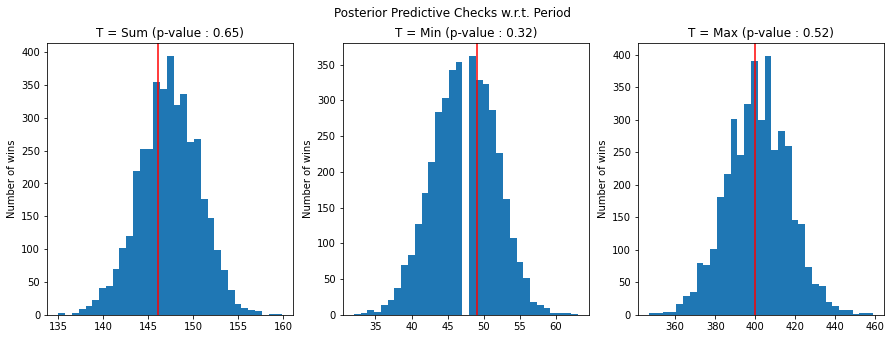

In [32]:
plot_ppc(
    score_pp_vi,
    observed_data,
    check,
    dim

)

The simulated and generated data are good fit in terms of $T$=Max. However, for $T$=Min and $T$=Sum, we observe slightly off results for $T$=Sum, and $T$=Min. This may be due to the simple, mean-field, variational approximation that we are using. 

**MAP Algorithm:**

Unfortunately, we cannot perform posterior predictive checks for MAP algorithm. Therefore, we plot the...

In [126]:
def glickman(observed_data_):
    
    observed_data = dict()

    for (key, value) in observed_data_.items():

        if 'test' not in key:
            observed_data[key] = value

    observed_data = pd.DataFrame.from_dict(
        observed_data
    )

    unique_periods = observed_data['id_period'].unique()

    unique_players = pd.concat([
        observed_data['id_white'],
        observed_data['id_black'],
    ]).unique()

    players = {
        k: Player() for k in unique_players
    }

    bce = [2, 1]
    ratings_by_time = []
    ratings_by_time_ = defaultdict(dict)

    while abs(bce[-2] - bce[-1]) > 1e-3:
        for period in unique_periods:

            all_games = observed_data[observed_data['id_period'] == period]

            for player in unique_players:

                white_games = all_games[all_games['id_white'] == player]

                black_games = all_games[all_games['id_black'] == player].rename(
                    columns={"id_white": "id_black",
                             "id_black": "id_white"})

                black_games['score'] = [not _ for _ in black_games['score']]

                games = pd.concat([white_games, black_games])

                if len(games) == 0:

                    players[player].did_not_compete()

                    rating = players[player].rating

                    ratings_by_time.append(
                        (period, player, rating)
                    )

                    ratings_by_time_[period][player] = (rating - 1500) / 173.7178

                else:

                    score = games['score'].tolist()

                    ratings = [players[k].rating for k in games['id_black']]

                    rds = [players[k].rd for k in games['id_black']]

                    players[player].update_player(ratings, rds, score)

                    rating = players[player].rating

                    ratings_by_time.append(
                        (period, player, rating)
                    )

                    ratings_by_time_[period][player] = (rating - 1500) / 173.7178

                bce.append(evaluate(ratings_by_time_, observed_data))

    bce.pop(0)

    bce.pop(0)

    ratings_by_time = pd.DataFrame(ratings_by_time).rename(
        columns={
            0: 'period',
            1: 'player',
            2: 'rating'
        }
    )

    ratings_by_time['rating'] = (ratings_by_time['rating'] - 1500) / 173.7178

    white_games = observed_data[observed_data['id_white'] == 3]

    black_games = observed_data[observed_data['id_black'] == 3].rename(
        columns={"id_white": "id_black",
                 "id_black": "id_white"})

    black_games['score'] = [not _ for _ in black_games['score']]

    games = pd.concat([white_games, black_games]).groupby('id_period').sum()

    iteration = list(range(len(bce)))

    delta = [bce[i + 1] - bce[i] for i in range(len(bce) - 1)]

    delta.insert(0, delta[0])

    plot_bce(iteration, bce, delta)

    score_ppc_glickman = pp_glickman(observed_data, ratings_by_time_)

    max_period = max(ratings_by_time_.keys())

    id_white_test = observed_data_['id_white_test']
    id_black_test = observed_data_['id_black_test']

    probs = []

    for (id_white, id_black) in zip(id_white_test,
                                    id_black_test):
        
        gamma_white = gammas[max_period][id_white]
        gamma_black = gammas[max_period][id_black]

        probs += [sigmoid(gamma_white - gamma_black)]

    return score_ppc_glickman, probs


In [104]:
gammas

['gamma[1,1]',
 'gamma[2,1]',
 'gamma[3,1]',
 'gamma[4,1]',
 'gamma[5,1]',
 'gamma[6,1]',
 'gamma[7,1]',
 'gamma[8,1]',
 'gamma[9,1]',
 'gamma[10,1]',
 'gamma[11,1]',
 'gamma[1,12]',
 'gamma[2,12]',
 'gamma[3,12]',
 'gamma[4,12]',
 'gamma[5,12]',
 'gamma[6,12]',
 'gamma[7,12]',
 'gamma[8,12]',
 'gamma[9,12]',
 'gamma[10,12]',
 'gamma[11,12]',
 'gamma[1,25]',
 'gamma[2,25]',
 'gamma[3,25]',
 'gamma[4,25]',
 'gamma[5,25]',
 'gamma[6,25]',
 'gamma[7,25]',
 'gamma[8,25]',
 'gamma[9,25]',
 'gamma[10,25]',
 'gamma[11,25]']

In [101]:

observed_data = pickle.load(open(chess_data, 'rb'))

players = [1, 12, 25]
periods = list(range(1, observed_data['n_period']+2))
gammas = []

observed_data_ = dict()

for (key, value) in observed_data.items():

    if 'test' not in key:
        observed_data_[key] = value

observed_data = pd.DataFrame.from_dict(
    observed_data_
)

observed_data['id_period'] += 1

wins = observed_data.groupby(['id_white','id_period']).sum().reset_index()

wins = wins[wins['id_white'].isin(players)]

for player in players:
    
    for period in periods:
        
        gammas.append('gamma[{},{}]'.format(period, player))
        
gammas = glicko_map.optimized_params_pd[gammas]

gammas_list = []

for row in wins.values:
    
    player = row[0]
    
    period = row[1]
    
    gamma = 'gamma[{},{}]'.format(period, player)
    
    gammas_list.append(gammas[gamma][0])
    
wins['gamma'] = gammas_list


In [97]:
observed_data['id_period'].min()

2

In [90]:
observed_data['n_period'].min()

11

In [77]:
gammas.shape

(3, 33)

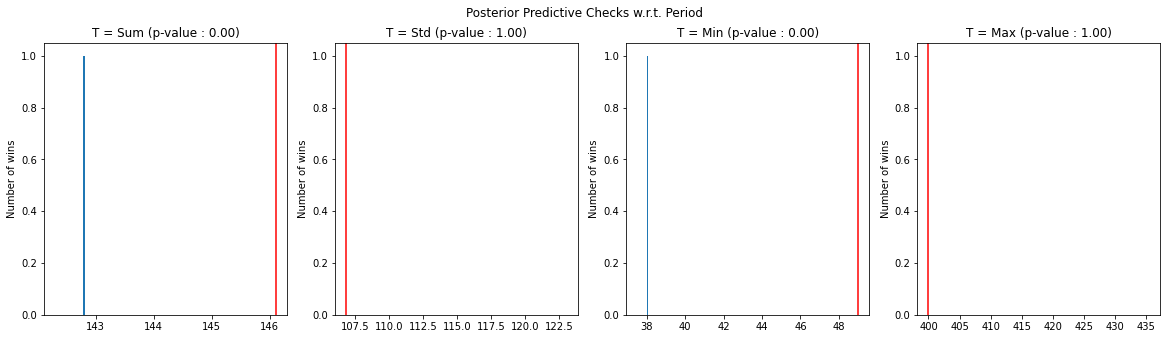

In [23]:
plot_ppc(
    score_pp_map,
    observed_data,
    check,
    dim
)

**Glickman's Algorithm:**

Below, we see the posterior predictive checks (with Bayesian p-values) for the **Glickman's** algorithm:

In [106]:
score_pp_glickman

(4000, 2570)

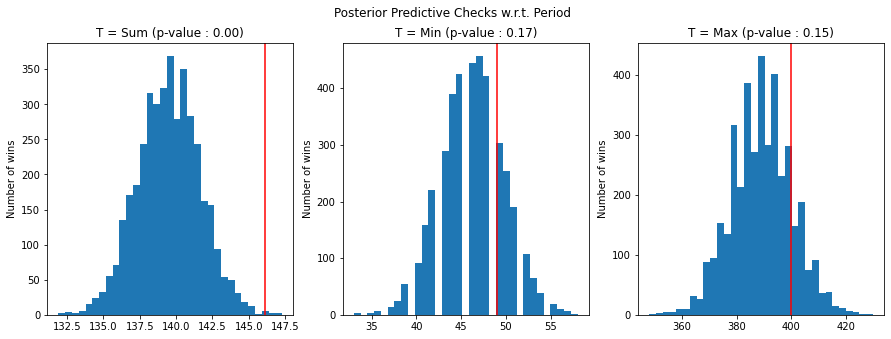

In [34]:
plot_ppc(
    score_pp_glickman,
    observed_data,
    check,
    dim
)

### 2.Performance Comparisons:


In [ ]:
evaluate_models(
    y=data["score_test"],
    model_MCMC=model_MCMC, 
    model_VB=model_VB, 
    model_MLE=model_MLE,
    model_glicko=glicko_test_probs
)